# Featuree Engineering with Weather Data

This notebook contains data transformation on [Weather Dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/). We will be using [tf.Transform](https://www.tensorflow.org/tfx/transform/get_started) here instead of TFX because it is easier to preserve the sequence of records using this framework. Dataset has 10-minute intervals of 14 different features such as air temperature, atmospheric pressure and humidity.

We will perform data preprocessing so that features can be used to train an LSTM network using Tensorflow and Keras. In particular we wil:


*   Explore and visualiuze the weather time series dataset and declare its schema
*   Transform the data for modeling using tf.Transform
*   Prepare training dataset windows from the output of tf.Transform



In [ ]:
!pip install tensorflow
!pip install tfx

In [ ]:
import os
import pprint
import tempfile
import urllib
import pandas as pd
import numpy as np

import absl
import tensorflow as tf
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from tfx.components import CsvExampleGen
from tfx.components import ExampleValidator
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.types import Channel
from tfx.types.standard_artifacts import ExternalArtifact

from tfx.components.transform.component import Transform

from google.protobuf.json_format import MessageToDict

print(f'TFX version: {tfx.__version__}')
print(f'Tensorflow version: {tf.__version__}')

TFX version: 1.15.1
Tensorflow version: 2.15.1


In [ ]:
# Create pipeline directory
!mkdir pipeline

# Create data directory
!mkdir -p data/climate

# Location of the pipeline metadata store
_pipeline_root = './pipeline/'

# Location of the data directory
_data_root = 'data/climate'

# Path to the raw training data
_data_filepath = os.path.join(_data_root, 'jena_climate_2009_2016.csv')

mkdir: cannot create directory ‘pipeline’: File exists


In [ ]:
# Download the dataset.
!wget -nc https://raw.githubusercontent.com/https-deeplearning-ai/MLEP-public/main/course2/week4-ungraded-lab/data/jena_climate_2009_2016.csv -P {_data_root}


--2024-07-17 23:56:56--  https://raw.githubusercontent.com/https-deeplearning-ai/MLEP-public/main/course2/week4-ungraded-lab/data/jena_climate_2009_2016.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43164220 (41M) [text/plain]
Saving to: ‘data/climate/jena_climate_2009_2016.csv’

jena_climate_2009_2 100%[===================>]  41.16M  67.1MB/s    in 0.6s    

2024-07-17 23:56:59 (67.1 MB/s) - ‘data/climate/jena_climate_2009_2016.csv’ saved [43164220/43164220]



In [ ]:
!head {_data_filepath}

"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30
01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50
01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.40,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,

In [ ]:
# Load the CSV into a dataframe
df = pd.read_csv(_data_filepath)

# Remove the quotes in the column names
df.columns = df.columns.str.replace('"', '')

# Save the changes
df.to_csv(f'{_data_filepath}', index=False)

!head {_data_filepath}

Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
01.01.2009 00:10:00,996.52,-8.02,265.4,-8.9,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.8,0.72,1.5,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.2,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.5,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.0,0.32,0.63,214.3
01.01.2009 01:00:00,996.5,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
01.01.2009 01:10:00,996.5,-7.62,265.81,-8.3,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
01.01.2009 01:20:00,996.5,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.5,118.6
01.01.2009 01:30:00,996.5,-7.91,265.52,-8.73,9

In [ ]:
# Initialize the InteractiveContext
context = InteractiveContext(pipeline_root=_pipeline_root)


In [ ]:
example_gen = CsvExampleGen(input_base=_data_root)
context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=CsvExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [ ]:
statistics_gen = StatisticsGen(examples=example_gen.outputs['examples'])

context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [ ]:
context.show(statistics_gen.outputs['statistics'])

In [ ]:
import matplotlib.pyplot as plt

# Color Palette
colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

# Dataset Columns
feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

# Plots each column as a time series
def visualize_plots(dataset, columns):
  features = dataset[columns]
  fig, axes = plt.subplots(nrows=len(columns)//2 + len(columns)%2, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k")
  for i, col in enumerate(columns):
    c = colors[i % (len(colors))]
    t_data = dataset[col]
    t_data.index = dataset.index
    t_data.head()
    ax = t_data.plot(ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(col),
            rot=25)
    ax.legend([col])
    plt.tight_layout()


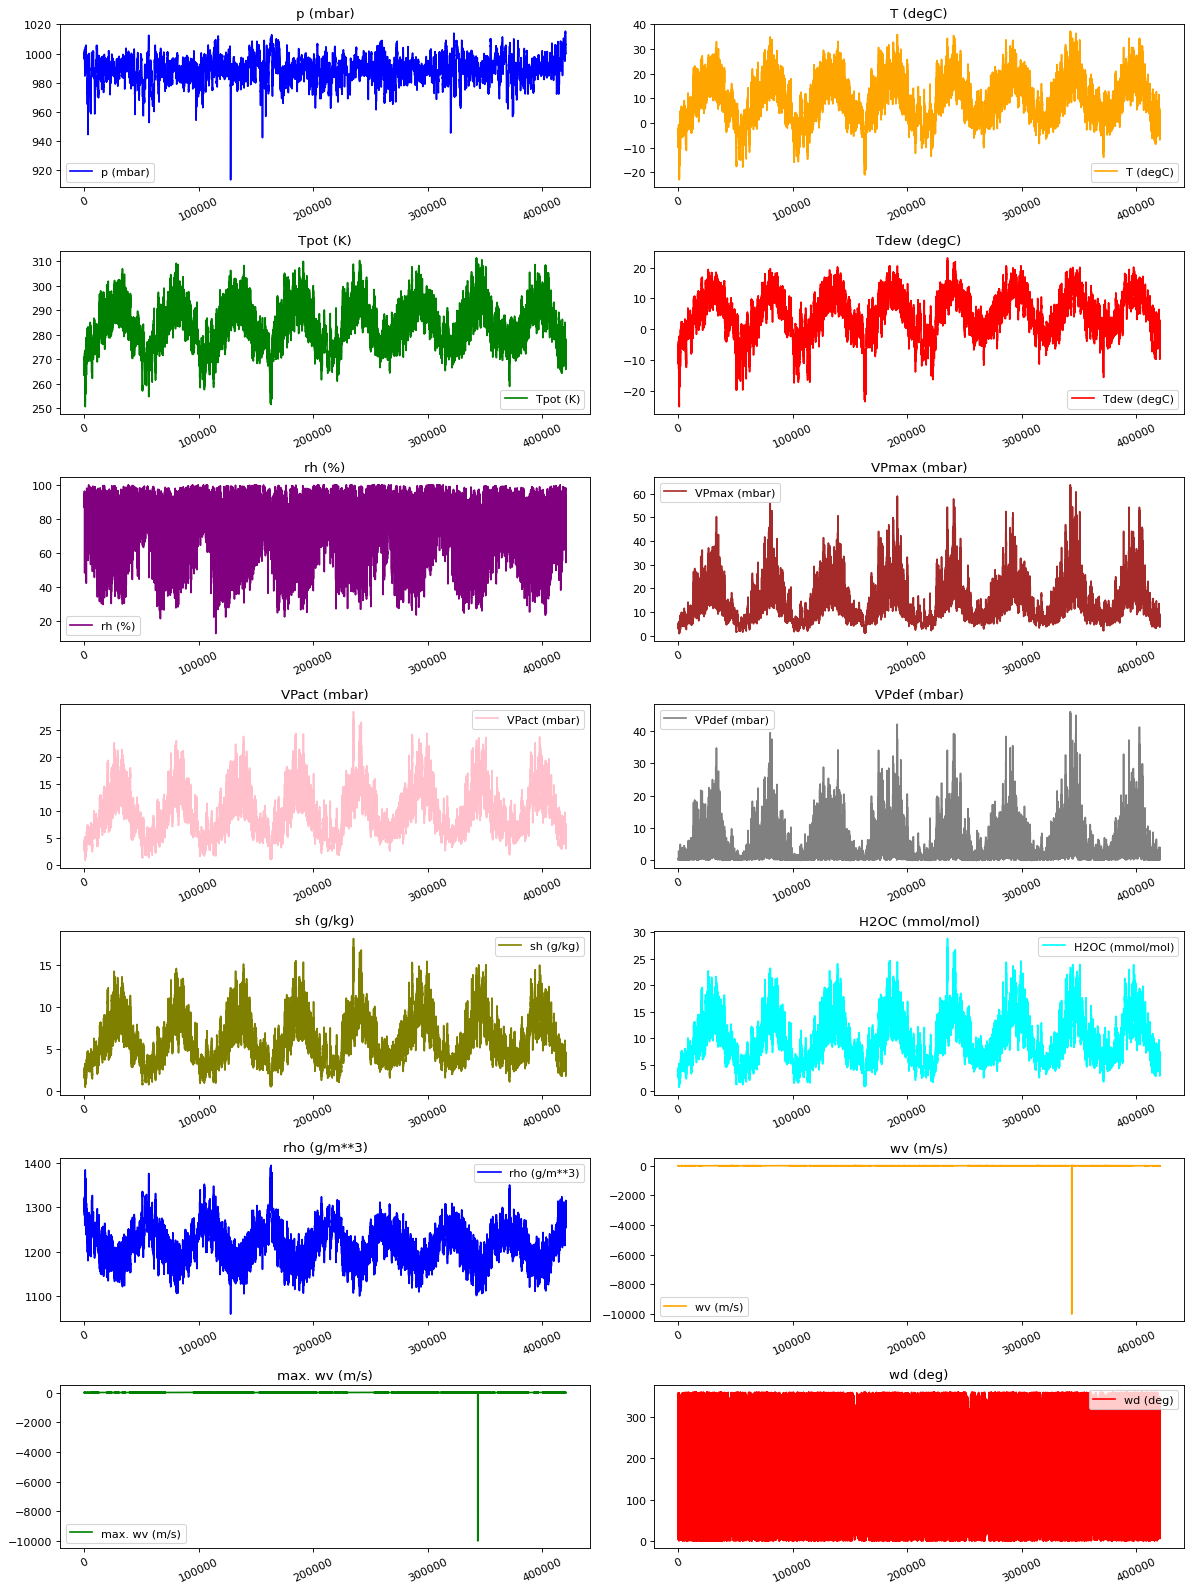

In [ ]:
visualize_plots(df, feature_keys)

In [ ]:
# Instantiate SchemaGen with the StatisticsGen ingested dataset
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=True
    )

# Run the component
context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [ ]:
# Visualize the schema
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'Date Time',BYTES,required,,-
'H2OC (mmol/mol)',FLOAT,required,,-
'T (degC)',FLOAT,required,,-
'Tdew (degC)',FLOAT,required,,-
'Tpot (K)',FLOAT,required,,-
'VPact (mbar)',FLOAT,required,,-
'VPdef (mbar)',FLOAT,required,,-
'VPmax (mbar)',FLOAT,required,,-
'max. wv (m/s)',FLOAT,required,,-


In [ ]:
# Instantiate ExampleValidator with the StatisticsGen and SchemaGen ingested data
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])

# Run the component.
context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [ ]:
# Visualize the results
context.show(example_validator.outputs['anomalies'])

In [ ]:
import seaborn as sns

def show_correlation_heatmap(dataframe):
  plt.figure(figsize=(20,20))
  cor = dataframe.corr()
  sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
  plt.show()

<ipython-input-19-ea2213f752f7>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = dataframe.corr()


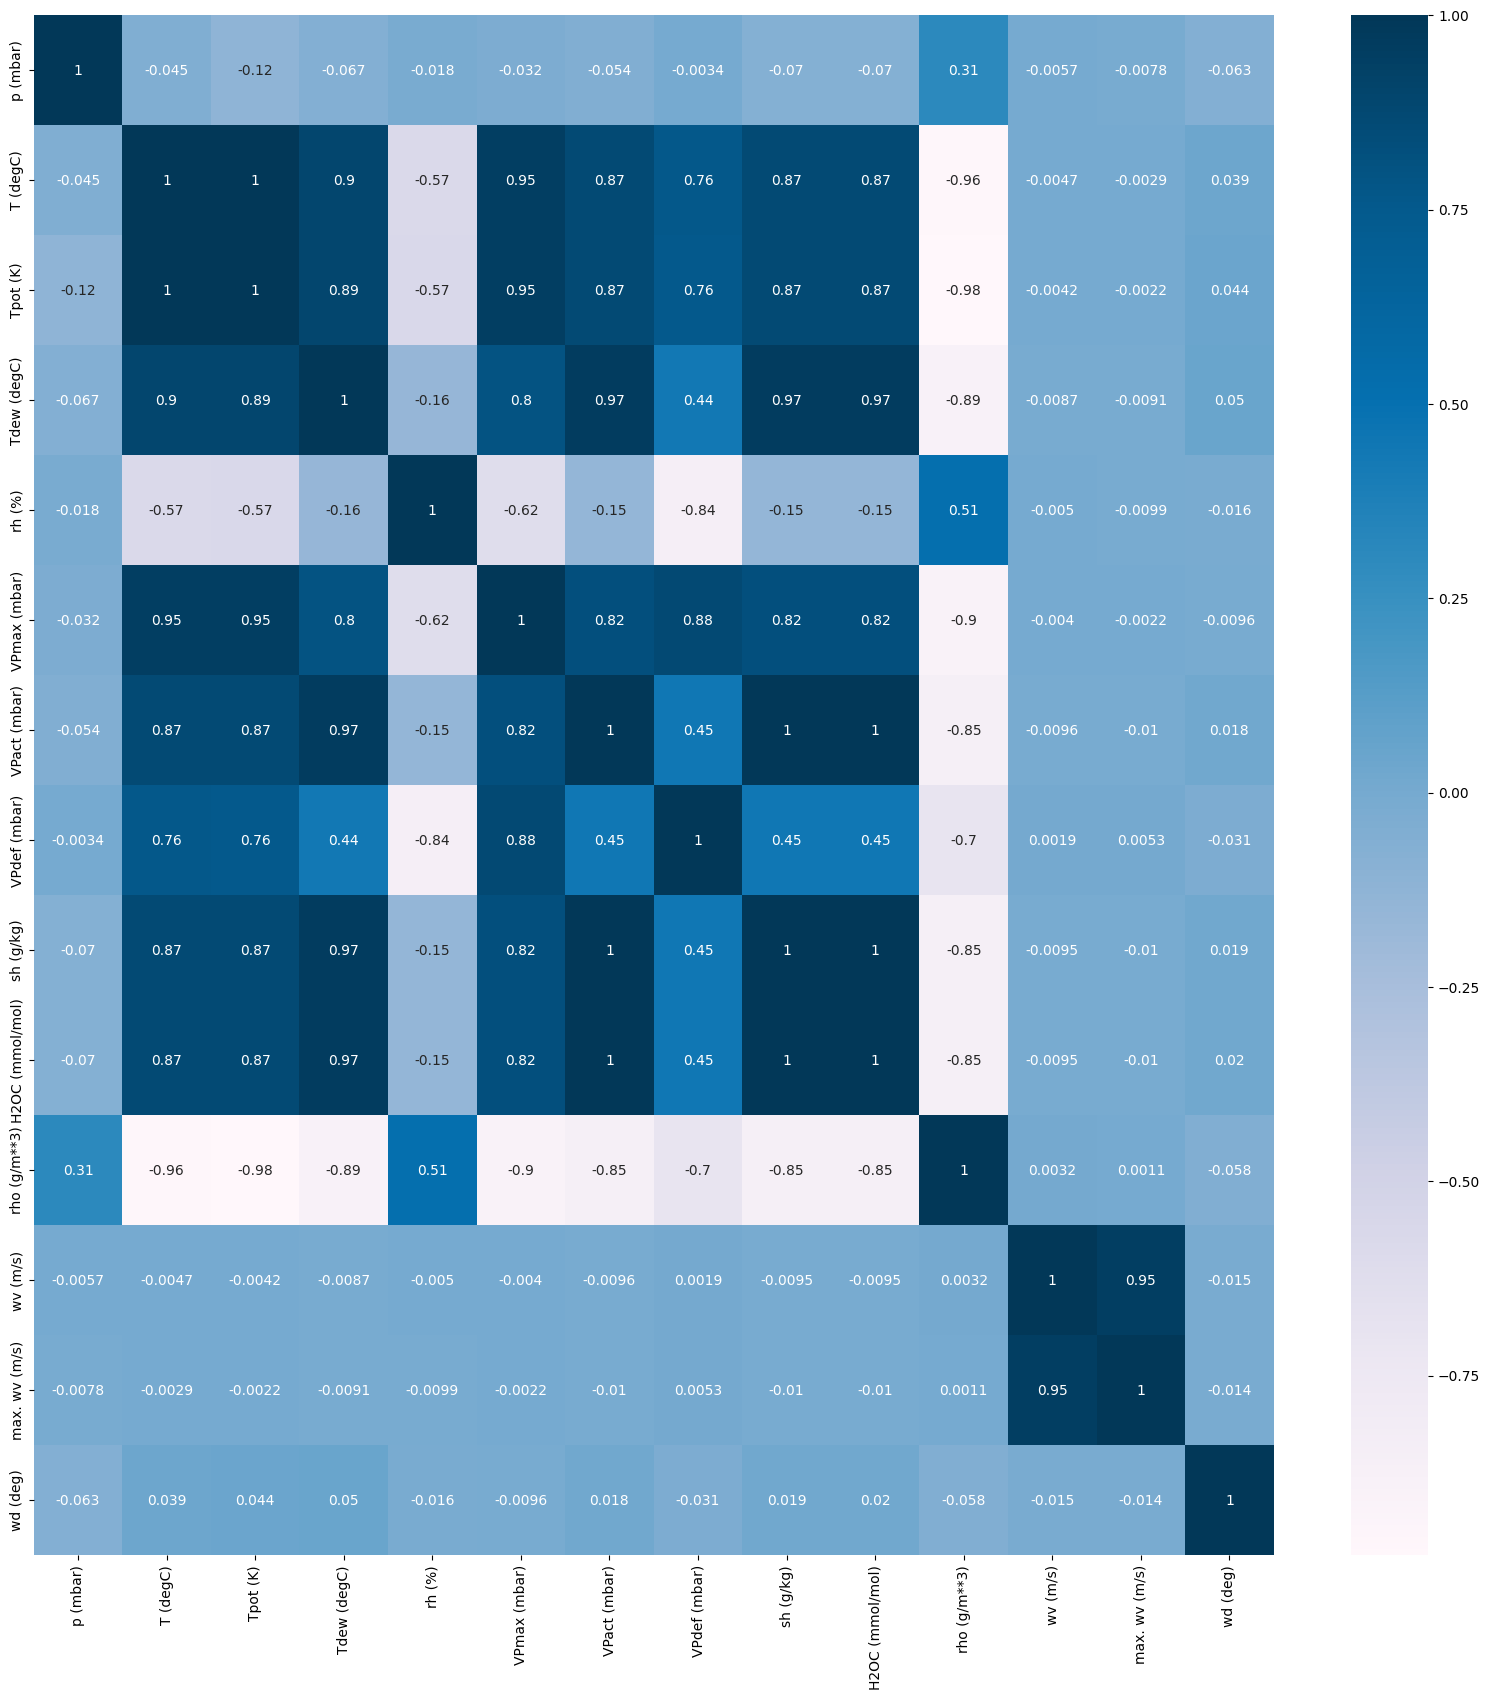

In [ ]:
show_correlation_heatmap(df)

We can observe from correlation heatmap that some features are highly correlated to the others. For example: VPmax(mbar) is highly correlated to features like Vpact(mbar), Tdew(degC) and Tpot(K). So we can drop all these features and retain VPmax(mbar). Same goes for other correlations.

In [ ]:
# Set the constants module filename
_weather_constants_module_file = 'weather_constants.py'

In [ ]:
%%writefile {_weather_constants_module_file}

# Selected numeric features to transform
SELECTED_NUMERIC_FEATURES = ['T (degC)', 'VPmax (mbar)', 'VPdef (mbar)', 'sh (g/kg)','rho (g/m**3)']

# Utility function for renaming the feature
def transformed_name(key):
    return key + '_xf'

Writing weather_constants.py


In [ ]:
# Set the transform module filename
_weather_transform_module_file = 'weather_transform.py'

In [ ]:
%%writefile {_weather_transform_module_file}

import tensorflow as tf
import tensorflow_transform as tft

import weather_constants
import tensorflow_addons as tfa

import math as m

# Features to filter out
FEATURES_TO_REMOVE = ["Tpot (K)", "Tdew (degC)","VPact (mbar)" , "H2OC (mmol/mol)", "max. wv (m/s)"]

# Unpack the contents of the constants module
_SELECTED_NUMERIC_FEATURE_KEYS = weather_constants.SELECTED_NUMERIC_FEATURES
_transformed_name = weather_constants.transformed_name

# Define the transformations
def preprocessing_fn(inputs):
    '''Preprocess input columns into transformed columns.'''

    outputs = inputs.copy()

    # Filter redundant features
    for key in FEATURES_TO_REMOVE:
        del outputs[key]

    # Convert degrees to radians
    pi = tf.constant(m.pi)
    wd_rad = inputs['wd (deg)'] * pi / 180.0


    # Calculate the wind x and y components.
    outputs['Wx'] = inputs['wv (m/s)'] * tf.math.cos(wd_rad)
    outputs['Wy'] = inputs['wv (m/s)'] * tf.math.sin(wd_rad)

    # Delete `wv (m/s)` after getting the wind vector
    del outputs['wv (m/s)']

    # Get day and year in seconds
    day = tf.cast(24*60*60, tf.float32)
    year = tf.cast((365.2425)*day, tf.float32)

    # Convert `Date Time` column into timestamps in seconds (using tfa helper function)
    timestamp_s = tfa.text.parse_time(outputs['Date Time'], time_format='%d.%m.%Y %H:%M:%S', output_unit='SECOND')
    timestamp_s = tf.cast(timestamp_s, tf.float32)

    # Convert timestamps into periodic signals
    outputs['Day sin'] = tf.math.sin(timestamp_s * (2 * pi / day))
    outputs['Day cos'] = tf.math.cos(timestamp_s * (2 * pi / day))
    outputs['Year sin'] = tf.math.sin(timestamp_s * (2 * pi / year))
    outputs['Year cos'] = tf.math.cos(timestamp_s * (2 * pi / year))

    # Delete unneeded columns
    del outputs['Date Time']
    del outputs['wd (deg)']

    # Final feature list
    FINAL_FEATURE_LIST =  ["p (mbar)",
    "T (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "rho (g/m**3)",
    "Wx",
    "Wy",
    "Day sin",
    'Day cos',
    'Year sin',
    'Year cos'
    ]

    # Scale selected numeric features
    for key in _SELECTED_NUMERIC_FEATURE_KEYS:
        outputs[key] = tft.scale_to_0_1(outputs[key])

    return outputs

Overwriting weather_transform.py


In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
# Ignore TF warning messages
tf.get_logger().setLevel('ERROR')

# Instantiate the Transform component
transform = Transform(
    examples = example_gen.outputs['examples'],
    schema = schema_gen.outputs['schema'],
    module_file = os.path.abspath(_weather_transform_module_file)
)

context.run(transform)

ExecutionResult(
    component_id: Transform
    execution_id: 7
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [ ]:
# Get the URI of the output artifact representing the transformed examples
train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
transformed_dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

In [ ]:
# Define a helper function to get individual examples
def get_records(dataset, num_records):
    '''Extracts records from the given dataset.
    Args:
        dataset (TFRecordDataset): dataset saved by ExampleGen
        num_records (int): number of records to preview
    '''

    # initialize an empty list
    records = []

    # Use the `take()` method to specify how many records to get
    for tfrecord in dataset.take(num_records):

        # Get the numpy property of the tensor
        serialized_example = tfrecord.numpy()

        # Initialize a `tf.train.Example()` to read the serialized data
        example = tf.train.Example()

        # Read the example data (output is a protocol buffer message)
        example.ParseFromString(serialized_example)

        # convert the protocol bufffer message to a Python dictionary
        example_dict = (MessageToDict(example))

        # append to the records list
        records.append(example_dict)

    return records

In [ ]:
# Get 3 records from the dataset
sample_records_xf = get_records(transformed_dataset, 3)

# Print the output
pp.pprint(sample_records_xf)

[{'features': {'feature': {'Day cos': {'floatList': {'value': [0.9988126]}},
                           'Day sin': {'floatList': {'value': [0.048717435]}},
                           'T (degC)': {'floatList': {'value': [0.24863161]}},
                           'VPdef (mbar)': {'floatList': {'value': [0.0047815694]}},
                           'VPmax (mbar)': {'floatList': {'value': [0.037886024]}},
                           'Wx': {'floatList': {'value': [-0.9119556]}},
                           'Wy': {'floatList': {'value': [0.47878695]}},
                           'Year cos': {'floatList': {'value': [0.9999552]}},
                           'Year sin': {'floatList': {'value': [0.009468557]}},
                           'p (mbar)': {'floatList': {'value': [996.52]}},
                           'rh (%)': {'floatList': {'value': [93.3]}},
                           'rho (g/m**3)': {'floatList': {'value': [0.7432129]}},
                           'sh (g/kg)': {'floatList': {'value': 

In [ ]:
# Constants to prepare the transformed data for modeling

WORKING_DIR = transform.outputs['transform_graph'].get()[0].uri
LABEL_KEY = 'T (degC)'
OBSERVATIONS_PER_HOUR = 6
HISTORY_SIZE = 120
FUTURE_TARGET = 12
BATCH_SIZE = 72
SHIFT = 1

In [ ]:
import tensorflow_transform as tft

# Get the output of the Transform component
tf_transform_output = tft.TFTransformOutput(os.path.join(WORKING_DIR))

# Get the index of the label key
index_of_label = list(tf_transform_output.transformed_feature_spec().keys()).index(LABEL_KEY)
print(index_of_label)

2


In [ ]:
def parse_function(example_proto):

    feature_spec = tf_transform_output.transformed_feature_spec()

    # Define features with the example_proto (transformed data) and the feature_spec using tf.io.parse_single_example
    features = tf.io.parse_single_example(example_proto, feature_spec)
    values = list(features.values())
    values[index_of_label], values[len(features) - 1] = values[len(features) - 1], values[index_of_label]

    # Stack the values along the first axis
    stacked_features = tf.stack(values, axis=0)

    return stacked_features

In [ ]:
def map_features_target(elements):
    features = elements[:HISTORY_SIZE]
    target = elements[-1:,-1]
    return (features, target)

In [ ]:
def get_dataset(path):

    # Instantiate a tf.data.TFRecordDataset passing in the appropiate path
    dataset = tf.data.TFRecordDataset(path, compression_type='GZIP')

    # Use the dataset's map method to map the parse_function
    dataset = dataset.map(parse_function)

    # Use the window method with expected total size. Define stride and set drop_remainder to True
    dataset = dataset.window(HISTORY_SIZE + FUTURE_TARGET, shift=SHIFT, stride=OBSERVATIONS_PER_HOUR, drop_remainder=True)

    # Use the flat_map method passing in an anonymous function that given a window returns window.batch(HISTORY_SIZE + FUTURE_TARGET)
    dataset = dataset.flat_map(lambda window: window.batch(HISTORY_SIZE + FUTURE_TARGET))

    # Use the map method passing in the previously defined map_features_target function
    dataset = dataset.map(map_features_target)

    # Use the batch method and pass in the appropiate batch size
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [ ]:
# Get the URI of the transformed examples
working_dir = transform.outputs['transformed_examples'].get()[0].uri

# Get the filename of the compressed examples
train_tfrecord_files = os.listdir(working_dir + '/Split-train')[0]

# Full path string to the training tfrecord files
path_to_train_tfrecord_files = os.path.join(working_dir, 'Split-train', train_tfrecord_files)

# Get the window datasets by passing the full path to the get_dataset function
train_dataset = get_dataset(path_to_train_tfrecord_files)

In [ ]:
for features, target in train_dataset.take(1):
    print(f'Shape of input features for a batch: {features.shape}')
    print(f'Shape of targets for a batch: {target.shape}')

Shape of input features for a batch: (72, 120, 13, 1)
Shape of targets for a batch: (72, 1, 1)
